## Sequence-to-sequence Tensorflow model for Amazon reviews

This notebook walks through training a [Sequence to sequence model](https://www.tensorflow.org/tutorials/seq2seq) with Tensorflow (version 1.1).

The model is currently used as the predictive backend for the SUMZ chrome extension, which takes in Amazon reviews on the current web page and displays a small summary of each review. The model is trained on the the [Amazon fine food reviews dataset.](https://www.kaggle.com/snap/amazon-fine-food-reviews) from Kaggle, which consists of 568K review-summary pairs.

The goal to work towards (chrome extension to summarize Amazon reviews):

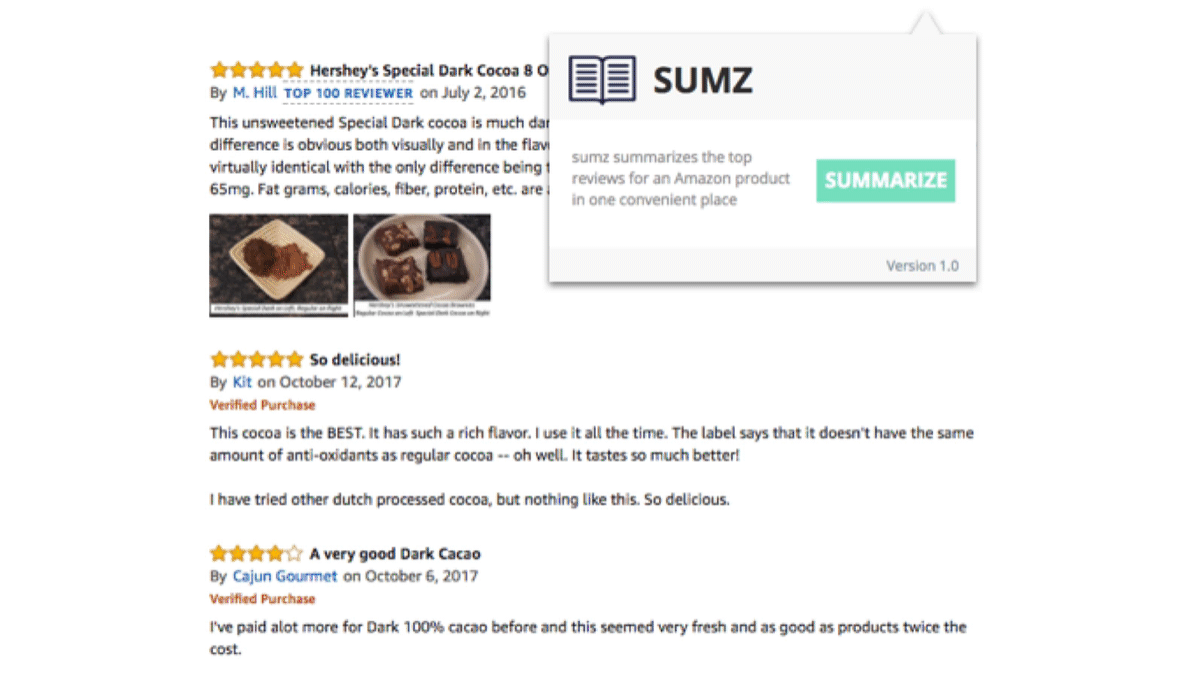

In [6]:
from IPython.display import Image
with open('./images/sumz9.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))

## Main objectives of project

1. Build end-to-end Tensorflow project, from data processing through deployment in production
2. Understand the sequence-to-sequence architecture, see how different architectures affect the model performance

## Pre-processing the data

<b>Steps:</b>
1. Exploring the data
2. Cleaning the text
3. Converting words to embeddings
4. Converting reviews/summaries to integer words
5. Creating the final data

In [42]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import time
from helpers import text_cleaning
import pickle

### 1. Exploring the data

Here we're cleaning up the Amazon reviews dataset from [Kaggle.](https://www.kaggle.com/snap/amazon-fine-food-reviews)

It has 568,454 food reviews on Amazon up to October 2012, with the following columns in Reviews.csv:


| Field        | Description
|:------------- |:-------------
| Id      | ID of review
| ProductId      | unique identifier for the product
| UserId | unqiue identifier for the user
| ProfileName | -- 
| HelpfulnessNumerator | number of users who found the review helpful
| HelpfulnessDenominator | number of users who indicated whether they found the review helpful
| Score | rating between 1 and 5
| Time | timestamp for the review  
| Summary | brief summary of the review  
| Text | text of the review

The only columns that we care about are <b>Text</b> and <b>Summary</b>; our motivation is to use the text-summary pairs to train our sequence-to-sequence model to generate its own summaries given a review text (which we'll be scraping from the Amazon product page).


In [11]:
reviews = pd.read_csv("Reviews.csv")

In [13]:
reviews = reviews.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], 1)
reviews = reviews.reset_index(drop=True)

In [15]:
reviews.head(10)

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
5,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,Yay Barley,Right now I'm mostly just sprouting this so my...
9,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [22]:
reviews_to_inspect = 5
review_idx = np.random.randint(low=0, high=len(reviews), size=reviews_to_inspect)

for i in review_idx:
    print("### REVIEW TEXT {}:\n{}".format(i+1, reviews.Text[i]))
    print("### SUMMARY {}: {}".format(i+1, reviews.Summary[i]))
    print("")

### REVIEW TEXT 436434:
I'm vegetarian and i thought this would be great for when i'm hungry at the office. I honestly did not like it. I had to add thai hot sause to give it more flavor. The noodles were super small.
### SUMMARY 436434: Never again.

### REVIEW TEXT 474095:
Stash is my favorite tea, and by far the Moroccan Mint is my favorite flavor.  I love mint, and the mix of green tea and mint is just delcious.
### SUMMARY 474095: I love Moroccan Mint

### REVIEW TEXT 82796:
Easy to make and a filling soup. It is hard to find in any stores in my area so am very happy Amazon has the mix for sale. I can eat the soup even though I am on Weight Watchers! If you want, you can add extra noodles and carrots when extra company arrives! Short time to cook. Love the soup!
### SUMMARY 82796: Homemade Taste

### REVIEW TEXT 173364:
Item says in stock and will ship in two days! Then after two days you get an email that says "Sorry for the inconveinence but your item is out of stock and will be

In [348]:
lengths_summaries = pd.DataFrame([len(sentence) for sentence in reviews.Summary], columns=['counts'])
lengths_texts = pd.DataFrame([len(sentence) for sentence in reviews.Text], columns=['counts'])
length_summaries = [len(sentence.split()) for sentence in reviews.Summary]
length_texts = [len(sentence.split()) for sentence in reviews.Text]


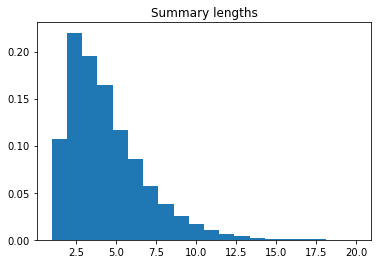

In [341]:
%matplotlib inline
plt.hist(lengths_summaries, normed=True, range=(1,20),bins=20)
plt.title('Summary lengths')
plt.show()

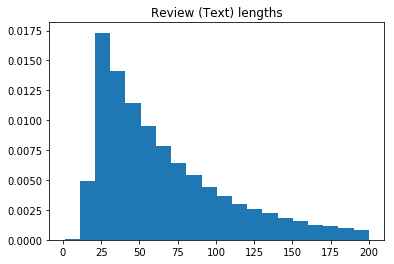

In [344]:
plt.hist(length_texts, normed=True, range=(1,2),bins=20)
plt.title('Review (Text) lengths')
plt.show()

### 2. Cleaning the text

In [39]:
class TextCleaner(object):
    
    def __init__(self, texts, remove_sw=True):
        self.texts = texts
        self.cleaned_texts = [self._clean_texts(text, remove_sw) for text in texts]
        
    def _clean_texts(self, text, remove_sw):
        text = text.lower().split()
        text = self._remove_contractions(text)
        text = self._remove_unwanted_chars(text)
        if remove_sw:
            text = self._remove_stopwords(text)
        return text
        
    def _remove_contractions(self, text):
        uncontracted_text = []
        for word in text:
            if word in text_cleaning.contractions:
                uncontracted_text.append(text_cleaning.contractions[word])
            else:
                uncontracted_text.append(word)
        return " ".join(uncontracted_text)
    
    def _remove_unwanted_chars(self, text):
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text) 
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
        text = re.sub(r'\'', ' ', text)
        return text
    
    def _remove_stopwords(self, text):
        stop_words = set(stopwords.words("english"))
        text = text.split()
        text = [word for word in text if not word in stop_words]
        text = " ".join(text)
        return text

In [40]:
# reviews_cleaner = TextCleaner(reviews.Text)
# clean_texts = reviews_cleaner.cleaned_texts
# summaries_cleaner = TextCleaner(reviews.Summary, remove_sw=False)
# clean_summaries = summaries_cleaner.cleaned_texts

In [41]:
for i in review_idx:
    print("### REVIEW TEXT {}:\n{}".format(i+1, clean_texts[i]))
    print("### SUMMARY {}: {}".format(i+1, clean_summaries[i]))
    print("")

### REVIEW TEXT 436434:
vegetarian thought would great hungry office honestly like add thai hot sause give flavor noodles super small
### SUMMARY 436434: never again 

### REVIEW TEXT 474095:
stash favorite tea far moroccan mint favorite flavor love mint mix green tea mint delcious
### SUMMARY 474095: i love moroccan mint

### REVIEW TEXT 82796:
easy make filling soup hard find stores area happy amazon mix sale eat soup even though weight watchers want add extra noodles carrots extra company arrives short time cook love soup
### SUMMARY 82796: homemade taste

### REVIEW TEXT 173364:
item says stock ship two days two days get email says sorry inconveinence item stock 10 days later wish amazon would go back instead letting dork website sell stuff bs probably last time business amazon called merchants
### SUMMARY 173364: bs

### REVIEW TEXT 185520:
dog likes food seamlessley fact switched frm puppy week later hes lookin good safe buy made usa
### SUMMARY 185520: all dog food seems like a 

#### Checkpoint -- saving cleaned reviews / summaries

In [ ]:
cleaned_texts_path = './checkpointed_data/cleaned_texts.p'
pickle.dump((clean_texts, clean_summaries), open(cleaned_texts_path, 'wb'))

In [ ]:
# Load in cleaned data from checkpoint

cleaned_texts_path = './checkpointed_data/cleaned_texts.p'
clean_texts, clean_summaries = pickle.load(open(cleaned_texts_path, mode='rb'))

### 3. Embedding the words into vectors

We can't feed text directly into the model, and instead of one-hot encoding (which will make massive sparse matrices for each word in which most characters are 0), we'll instead use pre-trained word embeddings.

Instead of word2vec or GloVe, we'll use [ConceptNet Numberbatch](https://github.com/commonsense/conceptnet-numberbatch). This seems to be the best of everything since it has an ensemble of the above-mentioned word embeddings.

<b>Formal attribution:</b>
<i>This data contains semantic vectors from ConceptNet Numberbatch, by
Luminoso Technologies, Inc. You may redistribute or modify the
data under the terms of the CC-By-SA 4.0 license.</i>


In [54]:
from collections import Counter

class TextEmbedder(object):
    
    def __init__(self, clean_summaries, clean_texts, word_threshold, embedding_dim=300):
        self.word_threshold = word_threshold
        self.embedding_dim= embedding_dim
        self.word_counts = self._get_word_counts(clean_summaries, clean_texts)
        self.embed_index = self._populate_embed_index()
        self.missing_words = self._find_missing_words()
        self.vocab_to_int, self.int_to_vocab = self._make_word_dicts()
        self.word_embedding_matrix = self._make_word_embed_matrix()
    
    def _get_word_counts(self, clean_summaries, clean_texts):
        total_counts = Counter()
        for sentence in (clean_summaries + clean_texts):
            for word in sentence.split():
                if word not in total_counts:
                    total_counts[word] = 1
                else:
                    total_counts[word] += 1
        print("Total size of all vocabulary: {}".format(len(total_counts)))
        return total_counts
    
    def _populate_embed_index(self):
        embed_index = {}
        with open('./numberbatch-en-17.06.txt', encoding='utf-8') as f:
            for line in f:
                values = line.split(' ')
                word = values[0]
                embedding = np.asarray(values[1:], dtype='float32')
                embed_index[word] = embedding
        print("Total word embeddings from CN:", len(embed_index))
        return embed_index
    
    def _find_missing_words(self):
        not_in_cn = 0
        missing_words = [word for word, count in self.word_counts.items() if (count > self.word_threshold and not word in self.embed_index)]
        print("Words missing from CN: {}, ({}% of our vocabulary)".format(len(missing_words), round(len(missing_words)/len(self.word_counts),4)*100))
        return missing_words
    
    def _make_word_dicts(self):
        vocab_to_int = {}
        value = 0
        for word, count in self.word_counts.items():
            if count >= self.word_threshold or word in self.embed_index:
                vocab_to_int[word] = value
                value += 1

        # Special codes to include
        codes = ["<UNK>","<PAD>","<EOS>","<GO>"]  
        for code in codes:
            vocab_to_int[code] = len(vocab_to_int)

        # Reverse dictionary
        int_to_vocab = {}
        for word, value in vocab_to_int.items():
            int_to_vocab[value] = word

        # Print stats
        usage_ratio = round(len(vocab_to_int) / len(self.word_counts),4)*100
        print("Total set of possible words:", len(self.word_counts))
        print("Number of words in our vocab:", len(vocab_to_int))
        print("Percent of words we're using: {}%".format(usage_ratio))

        return vocab_to_int, int_to_vocab
    
    def _make_word_embed_matrix(self):
        nb_words = len(self.vocab_to_int)
    
        # Create initial matrix of shape [nb_words,embedding_dim] with all zeros
        word_embedding_matrix = np.zeros((nb_words, self.embedding_dim), dtype=np.float32)
        for word, idx in self.vocab_to_int.items():
            if word in self.embed_index:
                word_embedding_matrix[idx] = self.embed_index[word]
            else:
                # If it's not in CN, we make a random embedding
                new_embedding = np.array(np.random.uniform(-1.0, 1.0, self.embedding_dim))
                self.embed_index[word] = new_embedding
                word_embedding_matrix[idx] = new_embedding

        print("Number of words in embedding matrix: ", len(word_embedding_matrix))
        print("Number of words in vocab_to_int    : ", len(self.vocab_to_int))
        return word_embedding_matrix

In [55]:
text_embedder = TextEmbedder(clean_summaries,
                             clean_texts, 
                             word_threshold=20, 
                             embedding_dim=300)

Total size of all vocabulary: 132884
Total word embeddings from CN: 417195
Words missing from CN: 3870, (2.91% of our vocabulary)
Total set of possible words: 132884
Number of words in our vocab: 59595
Percent of words we're using: 44.85%
Number of words in embedding matrix:  59595
Number of words in vocab_to_int    :  59595


Checking to see what an embedding looks like:

In [61]:
vocab_to_int, int_to_vocab, word_embedding_matrix = text_embedder.vocab_to_int, text_embedder.int_to_vocab, text_embedder.word_embedding_matrix

In [68]:
word_embedding_matrix[vocab_to_int['chocolate']][:50]

array([ 0.0081    , -0.0199    ,  0.222     ,  0.1085    ,  0.009     ,
       -0.0888    ,  0.2307    , -0.18709999,  0.0856    , -0.0004    ,
        0.0031    ,  0.0503    ,  0.0008    , -0.0833    , -0.0761    ,
        0.014     ,  0.0658    , -0.0816    ,  0.0144    , -0.0164    ,
       -0.0594    , -0.1864    ,  0.0469    , -0.1091    ,  0.0262    ,
       -0.155     , -0.0482    , -0.0073    , -0.0305    ,  0.0013    ,
       -0.1008    ,  0.0861    ,  0.0591    ,  0.1073    ,  0.133     ,
       -0.0101    , -0.0058    ,  0.0617    , -0.0682    ,  0.0405    ,
        0.13680001,  0.0406    ,  0.1338    , -0.0923    , -0.0663    ,
        0.0599    ,  0.086     ,  0.0402    , -0.0638    ,  0.0547    ], dtype=float32)

#### Checkpoint -- saving vocab_to_int, int_to_vocab, word_embedding_matrix

In [69]:
word_dicts = './checkpointed_data/word_dicts.p'
pickle.dump((vocab_to_int, int_to_vocab, word_embedding_matrix), open(word_dicts, 'wb'))

In [70]:
# Load in data from checkpoint
word_dicts = './checkpointed_data/word_dicts.p'
vocab_to_int, int_to_vocab, word_embedding_matrix = pickle.load(open(word_dicts, mode='rb'))

### 4. Convert reviews/summaries to integer words

In [58]:
'''
We're converting words to integers per vocab_to_int.
We're also replacing words we don't know with UNK's code.
And then adding an EOS token to end of each review.
'''
def convert_text_to_ints(text, vocab_to_int, word_count, unk_count, eos=False):
    all_word_ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int['<UNK>'])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int['<EOS>'])
        all_word_ints.append(sentence_ints)
    return all_word_ints, word_count, unk_count

word_count = 0
unk_count = 0
int_summaries, word_count, unk_count = convert_text_to_ints(clean_summaries, vocab_to_int, word_count, unk_count)

# We are only adding <EOS> to the review (not the summary)
int_texts, word_count, unk_count = convert_text_to_ints(clean_texts, vocab_to_int, word_count, unk_count, eos=True)

unk_perc = round(unk_count / word_count,4)*100
print("Total number of words in reviews (and summaries):", word_count)
print("Total number of UNKs in reviews (and summaries):", unk_count)
print("Percent of words that are UNK: {}%".format(unk_perc))

Total number of words in reviews (and summaries): 25679946
Total number of UNKs in reviews (and summaries): 192245
Percent of words that are UNK: 0.75%


Now all sentences are replaced with the integer values for their respective words.

Let's do the following to filter out the sentences we don't want to includes:
- Only include reviews that are between a predefined min / max sentence length (we don't want super long ones or super short ones)
- Remove reviews with too many UNK words

### 5. Creating final data

Only keeping reviews in length range we want, without too many unknown words, etc

In [345]:
def create_final_data(int_summaries,
                      int_texts, 
                      max_text_length, 
                      max_summary_length, 
                      unk_text_limit, 
                      unk_summary_limit):
    
    '''
    Makes the final sorted summaries and sorted texts for our model to process
    Params:
        int_summaries      : summaries in word-int form
        int_texts          : review texts in word-int form
        max_text_length    : maximum allowed review text size
        max_summary_length : maximum allowed summary size
        unk_text_limit     : max number of UNKs allowed in review text
        unk_summary_limit  : max number of UNKs allowed in summary
    '''
    
    sorted_summaries = []
    sorted_texts = []
    min_length = 2

    for length in range(min(lengths_texts.counts), max_text_length): 
        for count, words in enumerate(int_summaries):
            if (len(int_summaries[count]) >= min_length and
                len(int_summaries[count]) <= max_summary_length and
                len(int_texts[count]) >= min_length and
                unk_counter(int_summaries[count]) <= unk_summary_limit and
                unk_counter(int_texts[count]) <= unk_text_limit and
                length == len(int_texts[count])
               ):
                sorted_summaries.append(int_summaries[count])
                sorted_texts.append(int_texts[count])

    # Compare lengths to ensure they match
    print(len(sorted_summaries))
    print(len(sorted_texts))
    return sorted_summaries, sorted_texts

In [349]:
sorted_summaries, sorted_texts = create_final_data(int_summaries,
                                                   int_texts,
                                                   84, 13, 1, 0)

398505
398505


#### Checkpoint: Saving final data

In [350]:
# Dump the data to save for later
model_input_data_path = './checkpointed_data/model_input_data.p'
pickle.dump((sorted_summaries, sorted_texts), open(model_input_data_path, 'wb'))

In [351]:
# Load in model input data from checkpoint
model_input_data_path = './checkpointed_data/model_input_data.p'
sorted_summaries, sorted_texts = pickle.load(open(model_input_data_path, mode='rb'))
print(len(sorted_summaries), len(sorted_texts))

398505 398505


## Building the Model

### Model Architecture

<img src="images/nct-seq2seq.png"/>
<i>seq2seq model</i>
source: [WildML](http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/)

I'm building the model here piece by piece.

Some knobs in the architecture we can play with to test out model performance:
- For both encoder and decoder: <b>LSTM cell vs GRU cell</b>
- For the Encoder: <b>Bidirectional vs Unidirectional RNN </b>
- For the Decoder: <b>Attention vs. no Attention</b>
- Learning rate annealing <b>(Cosine annealing)</b>


In [81]:
import pickle
import time
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors

### Model Inputs

Our model has the following placeholders for input parameters:
- <b>inputs</b>: The integer-transformed full review
- <b>targets</b>: The integer-transformed summary of each review (with 'EOS' tags)
- <b>learning_rate</b>: model training learning rate
- <b>keep_probability</b>: For use in dropout
- <b>target_seq_len</b>: Length of each summary we input into the model for training on
- <b>max_target_seq_len</b>: Max length of the summaries we input into the model
- <b>source_seq_len</b>: Length of reviews inputted into the model

In [84]:
def model_input_placeholders():
    """
    Create model input placeholders
    : return: placeholder tensors
    """    
    inputs = tf.placeholder(tf.int32, [None,None], name='input')
    targets = tf.placeholder(tf.int32, [None,None])
    learning_rate = tf.placeholder(tf.float32)
    keep_probability = tf.placeholder(tf.float32, name='keep_probability')
    target_seq_len = tf.placeholder(tf.int32, (None,), name='target_seq_len')
    max_target_seq_len = tf.reduce_max(target_seq_len, name='max_target_seq_len')
    source_seq_len = tf.placeholder(tf.int32, (None,), name='source_seq_len')
    
    return inputs, targets, learning_rate, keep_probability, target_seq_len, max_target_seq_len, source_seq_len

### Encoder

We are doing two things in this layer:
1. Embedding the integer-value reviews into their word embeddings
2. Feeding those embeddings into the encoder RNN network

Here we're using the following Tensorflow APIs:
* [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) convenient method to use a provided embedding layer and convert our integer input into embeddings for the encoder
* [`tf.nn.bidirectional_dynamic_rnn`](https://www.tensorflow.org/api_docs/python/tf/nn/bidirectional_dynamic_rnn): The words in a review may depend heavily on sequences both before and after a given input, so we're using a [bidrectional RNN](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/bidirectional_rnn.py), consisting of:
    * Multilayerd [`tf.contrib.rnn.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell) 
    * The cell is wrapped in a [`tf.contrib.rnn.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper)

In [89]:
def embedded_encoder_input(input_data, word_embedding_matrix):
    return tf.nn.embedding_lookup(word_embedding_matrix, input_data)

def encoding_layer(encoder_inputs, rnn_size, 
                   source_seq_len, num_layers, 
                   keep_prob, 
                   encoder_style, 
                   base_cell):
    """
    Works with bidirectional and regular (unidirectional RNN)
    as specificed by the 'encoder_style' parameter that can be either
    'bidirectional_rnn' or 'unidirectional_rnn'
    
    Also can be passed in either a LSTMCell or GRUCell for 'LSTMCell' param
    """

    if encoder_style == 'unidirectional_rnn':
        print("UNIDIRECTIONAL ENCODER")
        print("ENCODER BASE CELL IS", base_cell)
        def make_cell(rnn_size):
            if base_cell == 'LSTM':
                enc_cell = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1,0.1,seed=2))
                enc_cell = tf.contrib.rnn.DropoutWrapper(enc_cell, output_keep_prob=keep_prob)
            else:
                enc_cell = tf.contrib.rnn.GRUCell(rnn_size)
                enc_cell = tf.contrib.rnn.DropoutWrapper(enc_cell, output_keep_prob=keep_prob)           
            return enc_cell
        enc_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
        enc_output, enc_state = tf.nn.dynamic_rnn(enc_cell, 
                                                  encoder_inputs, 
                                                  sequence_length=source_seq_len, 
                                                  dtype=tf.float32)
        
    else:
        print("BIDRECTIONAL ENCODER")
        print("ENCODER BASE CELL IS", base_cell)
        for layer in range(num_layers):
            with tf.variable_scope('encoder_{}'.format(layer)):
                
                if base_cell =='LSTM':
                    fwCell = tf.contrib.rnn.LSTMCell(num_units = rnn_size,
                                                      initializer = tf.random_uniform_initializer(-0.1, 0.1, seed=2))
                    bwCell = tf.contrib.rnn.LSTMCell(num_units = rnn_size,
                                                      initializer = tf.random_uniform_initializer(-0.1, 0.1, seed=2))
                else:
                    fwCell = tf.contrib.rnn.GRUCell(num_units = rnn_size)
                    bwCell = tf.contrib.rnn.GRUCell(num_units = rnn_size)
                
                single_rnn_cell_forward = tf.contrib.rnn.DropoutWrapper(cell = fwCell,
                                                                        output_keep_prob = keep_prob)
                single_rnn_cell_backward = tf.contrib.rnn.DropoutWrapper(cell = bwCell,
                                                                         output_keep_prob = keep_prob)
                enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(single_rnn_cell_forward,
                                                                        single_rnn_cell_backward,
                                                                        encoder_inputs,
                                                                        source_seq_len,
                                                                        dtype = tf.float32)
        enc_output = tf.concat(enc_output, 2) # Concatenate both outputs together
        
    return enc_output, enc_state

### Decoder

We'll actually have 2 types of decoders, one for training and one for inference. In the training decoder, we'll feed in the next value in the target sequence <b>regardless of what the decoder outputs at each step</b>. We'll still use the decoder outputs in training though to calculate the loss for the model.

This is called [Teacher Forcing](https://www.quora.com/What-is-the-teacher-forcing-in-RNN) since we're 'teaching' the decoder using actual target examples instead of letting it generate based on its own outputs at each time step. There are some known [issues](https://github.com/dennybritz/deeplearning-papernotes/blob/master/notes/professor-forcing.md) with this regarding generation but we'll use it for now!

This [notebook](https://github.com/udacity/deep-learning/blob/master/seq2seq/sequence_to_sequence_implementation.ipynb) from Udacity does a great job at explaining how the two decoders work.

#### Preprocessing the decoder input
The first step is to process what the decoder gets as input. We do the following preprocessing steps:
* We're removing the last element in each summary. Since the decoder doesn't need to see this last element (since the input to the last timestep is the second to last element in each target summary).
* We're adding a <b>`<GO>`</b> token at the beginning of each summary so the decoder knows to start decoding at that point

In [90]:
def process_decoder_input(target_data, vocab_to_int, batch_size):

    # Remove the last word (integer) from each target sequence
    ending = tf.strided_slice(target_data, [0,0], [batch_size,-1], [1,1])
    
    # Add the <GO> token to each target sequence
    decoder_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)
    
    return decoder_input

In [91]:
def embedded_decoder_input(input_data, word_embedding_matrix):
    return tf.nn.embedding_lookup(word_embedding_matrix, input_data)

#### Creating the decoder cell

The decoder cell is created very similarly to the encoder (though it's a single LSTM cell instead of a bidirectional RNN). This means we're using the [`tf.contrib.rnn.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell) again and wrapping it in a [`tf.contrib.rnn.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper).

<b>Attention Mechanism</b><br>

A new feature we're adding here is an [attention mechanism](http://www.wildml.com/2016/01/attention-and-memory-in-deep-learning-and-nlp/). Regular encoder-decoder seq2seq models use the final state of the encoder (the encoder's final output) as a sort of 'summary' of the entire input sentence -- in our case it means encoding the entire Amazon review into one fixed-length vector. Attention Mechanisms improve on this by allowing the decoder to 'focus' on different pieces of the input; it might weight certain words more heavily at different places in its output.

<img src="images/attentionmech.png">
<i>Image source:</i> 
[SPRO](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb)

The Bhadanau attention style seems to give better results per this [paper](https://arxiv.org/abs/1703.03906v2).

Here we're using the following Tensorflow APIs:
* Multilayered [`tf.contrib.rnn.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell) 
    * The cell is wrapped in a [`tf.contrib.rnn.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper)
* [`tf.contrib.seq2seq.BahdanauAttention`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BahdanauAttention) as the attention mechanism
    * Our LSTM cell wraps this using [`tf.contrib.seq2seq.DynamicAttentionWrapper`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/contrib/seq2seq/DynamicAttentionWrapper)
    * We're setting the initial state of our attention wrapper with [`tf.contrib.seq2seq.DynamicAttentionWrapperState`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/contrib/seq2seq/DynamicAttentionWrapperState)


In [102]:
def make_decoder_cell(rnn_size, 
                      num_layers, 
                      encoder_output, 
                      source_seq_len, 
                      keep_prob,
                      batch_size,
                      encoder_state, 
                      attention, 
                      base_cell):

    """
    Works with either GRU or basic LSTM cells, as 'GRUCell' or 'BasicLSTM'
    for the 'cell_style' parameter
    
    Also works with or without Attention mechanism, as specified by the
    'attention' parameter
    
    [@TODO Allow different attention mechanisms for comparison]
    """    
    print("DECODER BASE CELL", base_cell)
    if attention == True:
        print("DECODER ATTENTOIN IS TRUE")
        for layer in range(num_layers):
            with tf.variable_scope('decoder_{}'.format(layer)):
                if base_cell =='LSTM':
                    single_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                                  initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
                else:
                    single_cell = tf.contrib.rnn.GRUCell(rnn_size)
                dec_cell = tf.contrib.rnn.DropoutWrapper(single_cell, input_keep_prob=keep_prob)                    


        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                                   encoder_output,
                                                                   source_seq_len,
                                                                   normalize=False,
                                                                   name='BahdanauAttention')

        dec_cell = tf.contrib.seq2seq.DynamicAttentionWrapper(dec_cell,
                                                              attention_mechanism,
                                                              rnn_size)

        initial_state = tf.contrib.seq2seq.DynamicAttentionWrapperState(encoder_state[0],
                                                                        _zero_state_tensors(rnn_size, 
                                                                                            batch_size, 
                                                                                            tf.float32))
    
    else:
        print("DECODER ATTENTION IS FALSE")
        def make_cell(rnn_size):
            if base_cell == 'LSTM':
                dec_cell = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1,0.1,seed=2))
                dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)
            else:
                dec_cell = tf.contrib.rnn.GRUCell(rnn_size)
                dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)           
            return dec_cell            

        dec_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
        initial_state = encoder_state
        
    return dec_cell, initial_state 
    

In [103]:
def decoding_layer(input_data,
                   word_embedding_matrix,
                   num_layers, 
                   rnn_size, 
                   keep_prob, 
                   encoder_output, 
                   source_seq_len,
                   encoder_state,
                   batch_size,
                   vocab_size,
                   target_seq_len,
                   max_target_seq_len,
                   vocab_to_int,
                   attention,
                   base_cell):
    
    decoder_embedded_input = embedded_decoder_input(input_data, word_embedding_matrix)
    decoder_cell, initial_state = make_decoder_cell(rnn_size, 
                                                    num_layers, 
                                                    encoder_output, 
                                                    source_seq_len, 
                                                    keep_prob, 
                                                    batch_size,
                                                    encoder_state,
                                                    attention=attention,
                                                    base_cell=base_cell
                                                   )
    
    output_layer = Dense(vocab_size,
                        kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))

    # Training
    with tf.variable_scope("decode"):
        training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=decoder_embedded_input,
                                                            sequence_length = target_seq_len,
                                                            time_major=False)
        training_decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell,
                                                           training_helper,
                                                           initial_state,
                                                           output_layer)
        training_logits, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                               output_time_major=False,
                                                               impute_finished=True,
                                                               maximum_iterations=max_target_seq_len)
    
    with tf.variable_scope("decode", reuse=True): # Reuse same params for inference
        
        start_tokens = tf.tile(tf.constant([vocab_to_int['<GO>']], dtype=tf.int32), 
                               [batch_size], 
                               name='start_tokens')
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(word_embedding_matrix,
                                                                    start_tokens,
                                                                    vocab_to_int['<EOS>'])
        inference_decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell,
                                                            inference_helper,
                                                            initial_state,
                                                            output_layer)
        inference_logits, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                              output_time_major=False,
                                                              impute_finished=True,
                                                              maximum_iterations=max_target_seq_len)
    
    return training_logits, inference_logits

### Bringing it together: full seq2seq model

In [104]:
def full_seq2seq(input_data, 
                 word_embedding_matrix,
                 rnn_size,
                 source_seq_len,
                 num_layers,
                 keep_prob,
                 target_data,
                 vocab_to_int,
                 batch_size,
                 vocab_size,
                 target_seq_len,
                 max_target_seq_len,
                 encoder_style,
                 attention,
                 base_cell
                 ):
    

    
    # Encoding layer
    encoder_inputs = embedded_encoder_input(input_data, word_embedding_matrix)
    encoder_output, encoder_state = encoding_layer(encoder_inputs, 
                                                   rnn_size, 
                                                   source_seq_len, 
                                                   num_layers, 
                                                   keep_prob,
                                                   encoder_style=encoder_style,
                                                   base_cell=base_cell)
    
    # Decoding layer
    processed_decoder_input = process_decoder_input(target_data, 
                                                    vocab_to_int, 
                                                    batch_size)
    training_logits, inference_logits = decoding_layer(processed_decoder_input,
                                                       word_embedding_matrix,
                                                       num_layers, 
                                                       rnn_size, 
                                                       keep_prob, 
                                                       encoder_output, 
                                                       source_seq_len,
                                                       encoder_state,
                                                       batch_size,
                                                       vocab_size,
                                                       target_seq_len,
                                                       max_target_seq_len,
                                                       vocab_to_int,
                                                       attention=attention,
                                                       base_cell=base_cell)
    return training_logits, inference_logits

## Training the model

In [96]:
# Hyperparameters
epochs = 10
rnn_size = 256
batch_size = 64
num_layers = 2
lr = 0.001
keep_prob = 0.75

In [95]:
def pad_batch(batch_to_pad):
    max_size = max([len(item) for item in batch_to_pad])
    padded_batch = [item + [vocab_to_int['<PAD>']] * (max_size - len(item)) for item in batch_to_pad]
    return padded_batch

def get_batches(summaries, reviews, batch_size):
    for batch_i in range(0, len(reviews)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        reviews_batch = reviews[start_i:start_i + batch_size]
        pad_summaries_batch = pad_batch(summaries_batch)
        pad_reviews_batch = pad_batch(reviews_batch)
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        pad_reviews_lengths = []
        for review in pad_reviews_batch:
            pad_reviews_lengths.append(len(review))
        
        yield pad_summaries_batch, pad_reviews_batch, pad_summaries_lengths, pad_reviews_lengths

In [321]:
def build_and_train_model(word_embedding_matrix, 
                rnn_size,
                num_layers,
                keep_probability,
                vocab_to_int,
                batch_size,
                sorted_summaries,
                sorted_reviews,
                encoder_style='unidirectional_rnn',
                attention=True,
                base_cell='LSTM',
                checkpoint_file='./model_checkpoints/best_model.ckpt',
                losses_arr_path='./checkpointed_data/losses/LOSS_ARR.p'):
    

    train_graph = tf.Graph()
    with train_graph.as_default():
        
        inputs, targets, learning_rate, keep_probability, target_seq_len, max_target_seq_len, source_seq_len = model_input_placeholders()
        training_logits, inference_logits = full_seq2seq(tf.reverse(inputs, [-1]),
                                                         word_embedding_matrix,
                                                         rnn_size,
                                                         source_seq_len,
                                                         num_layers,
                                                         keep_probability,
                                                         targets,
                                                         vocab_to_int,
                                                         batch_size,
                                                         len(vocab_to_int)+1,
                                                         target_seq_len,
                                                         max_target_seq_len,                  
                                                         encoder_style=encoder_style,
                                                         attention=attention,
                                                         base_cell=base_cell)

        training_logits = tf.identity(training_logits.rnn_output, 'logits')
        inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
        
        masks = tf.sequence_mask(target_seq_len, max_target_seq_len, dtype=tf.float32, name='masks')
        
        with tf.name_scope("optimization"):
            
            cost = tf.contrib.seq2seq.sequence_loss(training_logits,
                                                    targets,
                                                    masks)
            
            optimizer = tf.train.AdamOptimizer(learning_rate)
            
            gradients = optimizer.compute_gradients(cost)
            capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
            train_operation = optimizer.apply_gradients(capped_gradients)

     
    
    start = 200000
    end = start + 50000
    
    sorted_summaries_short = sorted_summaries[start:end]
    sorted_reviews_short = sorted_reviews[start:end]
    
    
    display_step = 20 # Check training loss after every 20 batches
    stop = 10 # Stop training if average loss doesn't decrease in this mean update_checks
    per_epoch = 5 # update checks per epoch
    update_check = (len(sorted_reviews_short)//batch_size//per_epoch)-1

    update_loss = 0 
    batch_loss = 0
    summary_update_loss = [] # Record the update losses for saving improvements in the model
    avg_update_loss = [] # Record avg updates, for charting
    batch_infos = [] # losses and times for each batch, for charting

    checkpoint = checkpoint_file
    
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(1, epochs+1):
            update_loss = 0
            batch_loss = 0
            for batch_i, (summaries_batch, reviews_batch, summaries_lengths, reviews_lengths) in enumerate(
                    get_batches(sorted_summaries_short, sorted_reviews_short, batch_size)):
                start_time = time.time()
                _, loss = sess.run(
                    [train_operation, cost],
                    {inputs: reviews_batch,
                     targets: summaries_batch,
                     learning_rate: lr,
                     target_seq_len: summaries_lengths,
                     source_seq_len: reviews_lengths,
                     keep_probability: keep_prob})

                batch_loss += loss
                update_loss += loss
                end_time = time.time()
                batch_time = end_time - start_time
                batch_infos.append((round(loss,3),round(batch_time,3)))

                if batch_i % display_step == 0 and batch_i > 0:
                    print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                          .format(epoch_i,
                                  epochs, 
                                  batch_i, 
                                  len(sorted_reviews_short) // batch_size, 
                                  batch_loss / display_step, 
                                  batch_time*display_step))
                    batch_loss = 0

                if batch_i % update_check == 0 and batch_i > 0:
                    print("Average loss for this update:", round(update_loss/update_check,3), end="")
                    summary_update_loss.append(update_loss)
#                     pickle.dump(batch_infos, open(losses_arr_path, 'wb'))

                    # If the update loss is at a new minimum, save the model
                    if update_loss <= min(summary_update_loss):
                        print(' -- New Record!') 
                        stop_early = 0
#                         saver = tf.train.Saver() 
#                         saver.save(sess, checkpoint)

                    else:
                        print("-- No Improvement.")
                        stop_early += 1
                        if stop_early == stop:
                            break
                    update_loss = 0
    print("\n=====Finished training!\n")


In [97]:
def load_pickled_data():
    word_dicts_path = './checkpointed_data/word_dicts.p'
    model_input_data_path = './checkpointed_data/model_input_data.p'
    vocab_to_int, int_to_vocab, word_embedding_matrix = pickle.load(open(word_dicts_path, mode='rb'))
    sorted_summaries, sorted_reviews = pickle.load(open(model_input_data_path, mode='rb'))
    return vocab_to_int, int_to_vocab, word_embedding_matrix, sorted_summaries, sorted_reviews

In [98]:
vocab_to_int, int_to_vocab, word_embedding_matrix, sorted_summaries, sorted_reviews = load_pickled_data()

In [322]:
LSTM_BI_ATTN_CHECKPOINTDIR = './model_checkpoints/LSTM_BI_ATTN/best_model.ckpt'

''' 
    ENCODER STYLE:    BIDIRECTIONAL
    LSTM CELL STYLE:  LSTMCell
    ATTENTION:        TRUE
'''
print("\n#######\nTraining Bidirectional / LSTMCell / Attention\n#######")
tf.reset_default_graph()
tf.set_random_seed(1)
build_and_train_model(word_embedding_matrix, 
                      rnn_size,
                      num_layers,
                      keep_prob,
                      vocab_to_int,
                      batch_size,
                      sorted_summaries,
                      sorted_reviews,
                      encoder_style='bidirectional_rnn',
                      attention=True,
                      base_cell='LSTM',
                      checkpoint_file=LSTM_BI_ATTN_CHECKPOINTDIR,
                      losses_arr_path=LSTM_BI_ATTN_LOSSES_PATH)


#######
Training Bidirectional / LSTMCell / Attention
#######
BIDRECTIONAL ENCODER
ENCODER BASE CELL IS LSTM
DECODER BASE CELL LSTM
DECODER ATTENTOIN IS TRUE
Epoch   1/10 Batch   20/781 - Loss:  5.068, Seconds: 59.17
Epoch   1/10 Batch   40/781 - Loss:  2.997, Seconds: 62.57
Epoch   1/10 Batch   60/781 - Loss:  2.919, Seconds: 51.65
Epoch   1/10 Batch   80/781 - Loss:  2.781, Seconds: 70.92
Epoch   1/10 Batch  100/781 - Loss:  2.851, Seconds: 58.27
Epoch   1/10 Batch  120/781 - Loss:  2.768, Seconds: 56.42
Epoch   1/10 Batch  140/781 - Loss:  2.673, Seconds: 54.52
Average loss for this update: 3.111 -- New Record!
Epoch   1/10 Batch  160/781 - Loss:  2.680, Seconds: 64.03
Epoch   1/10 Batch  180/781 - Loss:  2.599, Seconds: 59.67
Epoch   1/10 Batch  200/781 - Loss:  2.709, Seconds: 52.91
Epoch   1/10 Batch  220/781 - Loss:  2.706, Seconds: 55.99
Epoch   1/10 Batch  240/781 - Loss:  2.674, Seconds: 44.22
Epoch   1/10 Batch  260/781 - Loss:  2.529, Seconds: 56.66
Epoch   1/10 Batch  280

KeyboardInterrupt: 

### Final model results
Note -- I was training this on my Macbook Pro but switched to an AWS EC2 instance with a GPU to train faster. The final results I got are below (this is the model being used in the summary generation below)

<img src="images/ec2loss2.png"><br>
<center><i>Results after training on GPU</i></center>

## Comparison with different architectures

In [ ]:
LSTM_UNI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/LSTM_UNI_ATTN_LOSS_ARR.p'
GRU_UNI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/GRU_UNI_ATTN_LOSS_ARR.p'
LSTM_BI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/LSTM_BI_ATTN_LOSS_ARR.p'
GRU_BI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/GRU_BI_ATTN_LOSS_ARR.p'
LSTM_UNI_LOSSES_PATH   = './checkpointed_data/losses/LSTM_UNI_LOSS_ARR.p'
GRU_UNI_LOSSES_PATH   = './checkpointed_data/losses/GRU_UNI_LOSS_ARR.p'
LSTM_BI_LOSSES_PATH   = './checkpointed_data/losses/LSTM_BI_LOSS_ARR.p'
GRU_BI_LOSSES_PATH   = './checkpointed_data/losses/GRU_BI_LOSS_ARR.p'

LSTM_UNI_ATTN_LOSSES = pickle.load(open(LSTM_UNI_ATTN_LOSSES_PATH, mode='rb'))
GRU_UNI_ATTN_LOSSES = pickle.load(open(GRU_UNI_ATTN_LOSSES_PATH, mode='rb'))
LSTM_BI_ATTN_LOSSES = pickle.load(open(LSTM_BI_ATTN_LOSSES_PATH, mode='rb'))
GRU_BI_ATTN_LOSSES = pickle.load(open(GRU_BI_ATTN_LOSSES_PATH, mode='rb'))
LSTM_UNI_LOSSES = pickle.load(open(LSTM_UNI_LOSSES_PATH, mode='rb'))
GRU_UNI_LOSSES = pickle.load(open(GRU_UNI_LOSSES_PATH, mode='rb'))
LSTM_BI_LOSSES = pickle.load(open(LSTM_BI_LOSSES_PATH, mode='rb'))
GRU_BI_LOSSES = pickle.load(open(GRU_BI_LOSSES_PATH, mode='rb'))

all_losses = [LSTM_UNI_ATTN_LOSSES,
              GRU_UNI_ATTN_LOSSES,
              LSTM_BI_ATTN_LOSSES,
              GRU_BI_ATTN_LOSSES,
              LSTM_UNI_LOSSES,
              GRU_UNI_LOSSES,
              LSTM_BI_LOSSES,
              GRU_BI_LOSSES]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def make_avgs(loss_tup, epochs_to_count=20):
    losses, times = zip(*loss_tup)
    update_check = (50000//64//5)-1
    total_groups = epochs_to_count * 5
    start_i = 0
    plotting = []
    for i in range(total_groups):
        end_i = start_i + update_check
        this_slice = losses[start_i:end_i]
        update_loss = np.sum(this_slice)
        plotting.append(round(update_loss/update_check,3))
        start_i += update_check

    return plotting

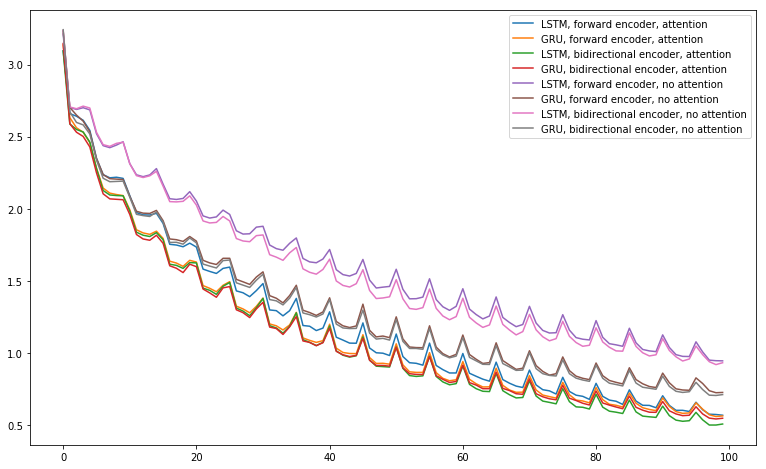

In [302]:
group_avgs = [make_avgs(losses,20) for losses in all_losses]
plt.figure(figsize=(13,8))
for g in group_avgs:
    plt.plot(g)
    
legend_list = ['LSTM, forward encoder, attention',
              'GRU, forward encoder, attention',
              'LSTM, bidirectional encoder, attention',
              'GRU, bidirectional encoder, attention',
              'LSTM, forward encoder, no attention',
              'GRU, forward encoder, no attention',
              'LSTM, bidirectional encoder, no attention',
              'GRU, bidirectional encoder, no attention']
plt.legend(legend_list, loc='upper right')

## Testing out summary generation

In [323]:
from helpers import text_cleaning

def create_summary(input_review):
    
    # Clean the text to get it ready for the model
    text = text_cleaning.clean_text(input_review)
    text_int = [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in text.split()]
    
    # Load in the model from the checkpoint
    checkpoint = "./model_checkpoints_new/LSTM_BI_ATTN2/best_model.ckpt"
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(checkpoint + '.meta')
        loader.restore(sess, checkpoint)
        
        # The input tensors for inference
        input_data = loaded_graph.get_tensor_by_name('input:0')
        inference_logits = loaded_graph.get_tensor_by_name('predictions:0')
        source_seq_len = loaded_graph.get_tensor_by_name('source_seq_len:0')
        target_seq_len = loaded_graph.get_tensor_by_name('target_seq_len:0')
        keep_probability = loaded_graph.get_tensor_by_name('keep_probability:0')
        
        # Run the graph to get the summary logits
        summary_logits = sess.run(inference_logits, { input_data: [text_int] * batch_size,
                                                      target_seq_len: [np.random.randint(5,8)],
                                                      source_seq_len: [len(text_int)] * batch_size,
                                                      keep_probability: 1.0
                                                    })
        # This returns a batch_size - length matrix of logits, so we just need the first one
        summary_logits = summary_logits[0]
        
        # Convert back to human text to print out
        pad = vocab_to_int["<PAD>"]
        
        return " ".join([int_to_vocab[i] for i in summary_logits if i != pad])

In [316]:


reviews_to_inspect = 5
rand_idx = np.random.randint(low=200000, high=250000, size=reviews_to_inspect)
generated_summaries1 = [create_summary(reviews.Text[i]) for i in rand_idx]

for idx, i in enumerate(rand_idx):
    print("### REVIEW TEXT {}:\n{}".format(i+1, reviews.Text[i]))
    print("### SUMMARY {}: {}".format(i+1, reviews.Summary[i]))
    print("### GENERATED SUMMARY: {}".format(generated_summaries1[idx]))
    print("")

INFO:tensorflow:Restoring parameters from ./model_checkpoints_new/LSTM_BI_ATTN/best_model.ckpt
INFO:tensorflow:Restoring parameters from ./model_checkpoints_new/LSTM_BI_ATTN/best_model.ckpt
INFO:tensorflow:Restoring parameters from ./model_checkpoints_new/LSTM_BI_ATTN/best_model.ckpt
INFO:tensorflow:Restoring parameters from ./model_checkpoints_new/LSTM_BI_ATTN/best_model.ckpt
INFO:tensorflow:Restoring parameters from ./model_checkpoints_new/LSTM_BI_ATTN/best_model.ckpt
### REVIEW TEXT 223456:
THE PRODUCT IS GOOD, BUT I HAD FOUND IT CHEAPER AT A DOLLAR STORE NEAR BY AND I WAS TOO LATE TO CANCEL
### SUMMARY 223456: THE ORIGINAL
### GENERATED SUMMARY: very disappointed

### REVIEW TEXT 232876:
I love that it comes in easy to use bowls, that I have several options to cook it and the taste is far better than any cup-o-noodle I've found. These are inexpensive and easy to keep in my desk for those days when lunch is too far away.
### SUMMARY 232876: Better than super cheap ramen.... SPICY!
#

## Exporting the model

Since we're going to use this model for inference in a production app (the Sumz chrome extension), we need to export it. Here's a great [tutorial](https://blog.metaflow.fr/tensorflow-how-to-freeze-a-model-and-serve-it-with-a-python-api-d4f3596b3adc) on how to go about this, which I'm following below.

The gist is that we want to export just what we need for inference -- this significantly pares down the bloat in the model so we can serve it easier in production. We really just want the model and its weights in one file; essentially we want to freeze the model.

The <b>checkpoints</b> we were saving above while training look like this:
<img src="images/checkpoints_files.png"><br>
These are the following:
* <b>best_model.ckpt.meta</b> This is holding the graph and metadata
* <b>best_model.ckpt.index</b> Immutable key-value table that links each serialized tensor name and where to find it in the .data files
* <b>best_model.ckpt.data-00000-of-00001</b> Holds the weights of the model
* <b>checkpoint</b> High-level helper for loading different checkpoint files

For production purposes we can 'freeze' the meta-graph, restore the weights. We'll also only need whatever is necessary for inference, which the following functino helps us do.

The serialized frozen model is saved as a [ProtoBuf](https://developers.google.com/protocol-buffers/) file (a super compressed way to save the model and reload it); this is the final frozen model we'll use to serve to real users!

In [317]:
MODEL_PATH = './models/frozen_seq2seq_model_lba.pb'
with tf.Session(graph=tf.Graph()) as sess:
    loader = tf.train.import_meta_graph('./model_checkpoints_new/LSTM_BI_ATTN/best_model.ckpt.meta')
    loader.restore(sess, './model_checkpoints_new/LSTM_BI_ATTN/best_model.ckpt')
    
    # We want the just the predictions operation (and all necessary variables for that)
    # This converts those variables to constants (freezing them)
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess,
                                                                    tf.get_default_graph().as_graph_def(),
                                                                    output_node_names=["predictions"])
    output_graph = MODEL_PATH
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in final graph" % len(output_graph_def.node))

INFO:tensorflow:Restoring parameters from ./model_checkpoints_new/LSTM_BI_ATTN/best_model.ckpt
INFO:tensorflow:Froze 15 variables.
Converted 15 variables to const ops.
529 ops in final graph


## Next Steps

You can find the model working through the Sumz chrome extension (link); clearly it's not perfect at its summaries but it's cool that it can have some utility.

Importantly I got to cover some of the concepts I wanted to learn more about, including:
* Sequence to sequence models
* Attention Mechanisms
* Serving the model in a production environment (exporting)

There are definitely some improvements to be made:
* <b>Better data</b>: this model uses a fine foods dataset, and only a small portion of it. It'd be great to train it was a much bigger Amazon reviews set like [SNAP](https://snap.stanford.edu/data/web-Amazon.html) (34M reviews)
* <b>Fine tuning on the model</b>: Especially the Attention Mechanism, and other architectures, * <b>Beam Search</b>
* <b>Bucketing</b>: The review lengths vary wildly for Amazon reviews; having buckets could really help (putting reviews within a certain length in one bucket) so that the model can be trained based on that. Also having more types of products in the reviews could help inform the model in terms of summaries
* <b>Distributed training (Uber's Horovod) </b>
* <b>Learning rate annealing (SGDR) </b>
<img src="images/lran.png"><br>